In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
test_ds = ECGDataset("data/mit_bih_test.csv")
val_ds = ECGDataset("data/mit_bih_val.csv")


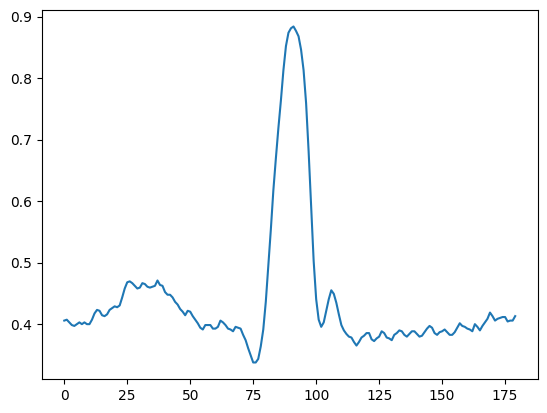

In [41]:
plt.plot(train_ds.df[0])

In [22]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, X in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X).unsqueeze(0)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for seq_true in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true).unsqueeze(0)    # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [26]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 64)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [27]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=10,
  lr=5e-4,
  batch_size=1
)

loss: 77.217941  [    1/77720]
loss: 6.451981  [10001/77720]
loss: 8.517079  [20001/77720]
loss: 6.046573  [30001/77720]
loss: 3.904035  [40001/77720]
loss: 6.565125  [50001/77720]
loss: 4.586092  [60001/77720]
loss: 7.715891  [70001/77720]
Epoch 1: train loss = 8.94174110211175, val loss = 7.901907895167219
loss: 5.856216  [    1/77720]
loss: 22.042086  [10001/77720]
loss: 19.055399  [20001/77720]
loss: 13.500370  [30001/77720]
loss: 6.941460  [40001/77720]
loss: 8.360540  [50001/77720]
loss: 9.990799  [60001/77720]
loss: 3.260803  [70001/77720]
Epoch 2: train loss = 9.417088819878407, val loss = 5.348169331678212
loss: 3.708012  [    1/77720]
loss: 4.349338  [10001/77720]
loss: 1.759845  [20001/77720]
loss: 3.509431  [30001/77720]
loss: 2.174155  [40001/77720]
loss: 3.297513  [50001/77720]
loss: 2.063116  [60001/77720]
loss: 2.692505  [70001/77720]
Epoch 3: train loss = 3.89584790021948, val loss = 3.034796849152383
loss: 4.855028  [    1/77720]
loss: 3.255022  [10001/77720]
loss: 1.

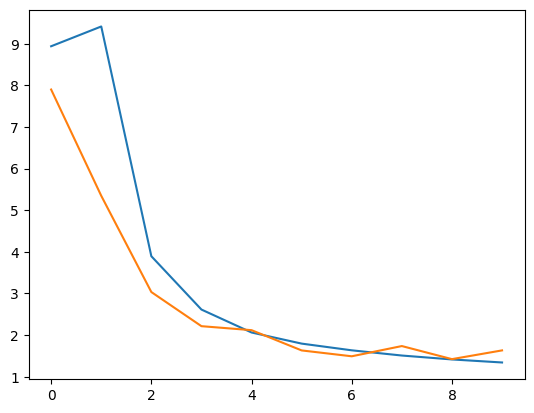

In [39]:
plt.plot(history["train"])
plt.plot(history["val"])

In [28]:
torch.save(model.state_dict(), "models/lstmae_5000.pth")

In [29]:
torch.load("models/lstmae_5000.pth", map_location=torch.device('cpu'))

OrderedDict([('encoder.rnn1.weight_ih_l0',
              tensor([[-1.6013e+00],
                      [-2.8503e+00],
                      [-1.0703e+00],
                      [-2.7515e+00],
                      [-2.7786e+00],
                      [-3.7222e-01],
                      [-7.1606e-01],
                      [-1.1678e+00],
                      [-2.2002e+00],
                      [-9.7163e-01],
                      [-1.7082e+00],
                      [-3.0955e+00],
                      [-1.2656e-01],
                      [-2.1166e+00],
                      [-3.9506e-01],
                      [-1.8084e+00],
                      [-1.7360e+00],
                      [-2.2210e+00],
                      [-1.7980e+00],
                      [-1.6448e+00],
                      [-1.5610e+00],
                      [-1.5841e+00],
                      [-2.2630e+00],
                      [-1.2453e+00],
                      [-1.5123e+00],
                      [-2.0951e+

In [31]:
model = model.to(device="cpu")

In [32]:
train_ds.__getitem__(0)

tensor([[0.4058],
        [0.4072],
        [0.4029],
        [0.3986],
        [0.3971],
        [0.4000],
        [0.4029],
        [0.4000],
        [0.4029],
        [0.4000],
        [0.4000],
        [0.4072],
        [0.4174],
        [0.4232],
        [0.4217],
        [0.4145],
        [0.4130],
        [0.4159],
        [0.4232],
        [0.4261],
        [0.4290],
        [0.4275],
        [0.4304],
        [0.4435],
        [0.4580],
        [0.4681],
        [0.4696],
        [0.4667],
        [0.4623],
        [0.4580],
        [0.4594],
        [0.4667],
        [0.4652],
        [0.4609],
        [0.4594],
        [0.4609],
        [0.4623],
        [0.4710],
        [0.4638],
        [0.4623],
        [0.4522],
        [0.4478],
        [0.4478],
        [0.4435],
        [0.4362],
        [0.4319],
        [0.4246],
        [0.4203],
        [0.4145],
        [0.4217],
        [0.4203],
        [0.4130],
        [0.4072],
        [0.4014],
        [0.3942],
        [0

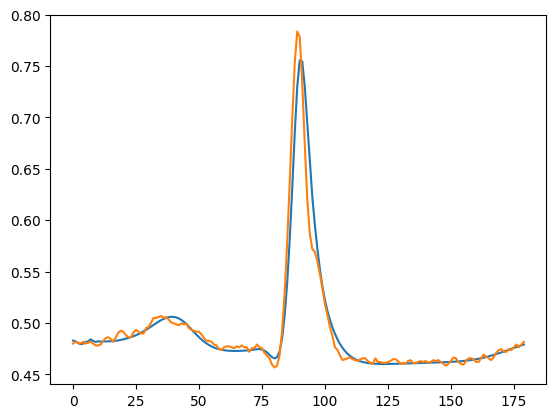

In [36]:
plt.plot(model(test_ds.__getitem__(10)).cpu().detach().numpy().squeeze())
plt.plot(test_ds.__getitem__(10).cpu().detach().numpy().squeeze())